# Water Detection Filter (Classic Image Processing)

**Obiettivo**: Identificare e evidenziare aree con acqua (laghi, mare) nelle immagini usando tecniche di image processing classico.

**Caratteristiche dell'acqua**:
- Dominanza del canale blu (B > R, B > G)
- Hue nello spazio HSV nel range blu/ciano (90-130° in OpenCV)
- Bassa luminosità rispetto a nuvole
- Rapporto blu elevato: B / (R+G+B)

**Approccio**:
1. Indice acqua: rapporto blu B / (R+G+B)
2. Filtro HSV: range hue blu/ciano
3. Combinazione filtri con operazioni morfologiche
4. Visualizzazione: overlay ciano + side-by-side
5. Valutazione su immagini water vs altre categorie

## 1. Imports

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path
import random
from typing import Tuple, List

# Set random seed
random.seed(42)
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 100

%matplotlib inline

print("Imports completed successfully")

Imports completed successfully


## 2. Configuration

In [2]:
# Paths
DATA_DIR = Path('../data')
CATEGORIES = ['cloudy', 'desert', 'green_area', 'water']
TARGET_SIZE = (64, 64)

# Filter parameters
BLUE_RATIO_THRESHOLD = 0.38  # Minimum blue ratio B/(R+G+B)

# HSV thresholds for blue/cyan hue
# OpenCV Hue range: 0-179 (blue/cyan is roughly 90-130)
HSV_THRESHOLDS = {
    'hue_min': 90,        # Lower bound for blue/cyan hue
    'hue_max': 130,       # Upper bound for blue/cyan hue
    'sat_min': 30,        # Minimum saturation (avoid grayish)
    'val_min': 30,        # Minimum value (avoid too dark)
}

# Additional constraints to avoid confusion with sky/clouds
MAX_VALUE_THRESHOLD = 200  # Maximum brightness (avoid bright sky)

# Morphological operations
MORPH_KERNEL_SIZE = 3

# Visualization
WATER_COLOR = (0, 255, 255)  # Cyan in RGB
OVERLAY_ALPHA = 0.4

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Blue ratio threshold: {BLUE_RATIO_THRESHOLD}")
print(f"HSV thresholds: {HSV_THRESHOLDS}")

Data directory: /Users/aldojacopo/forme-idee/notebooks/../data
Blue ratio threshold: 0.38
HSV thresholds: {'hue_min': 90, 'hue_max': 130, 'sat_min': 30, 'val_min': 30}


## 3. Utility Functions

In [3]:
def load_and_resize_image(img_path: Path, target_size: Tuple[int, int] = TARGET_SIZE) -> np.ndarray:
    """
    Load an image and resize it to target size.
    
    Args:
        img_path: Path to image file
        target_size: (width, height) tuple
    
    Returns:
        numpy array (H, W, 3) in RGB format
    """
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize(target_size, Image.LANCZOS)
    return np.array(img_resized)


def load_sample_images(category: str, n_samples: int = 10) -> List[np.ndarray]:
    """
    Load random sample images from a category.
    """
    category_path = DATA_DIR / category
    image_files = list(category_path.glob('*.jpg'))
    sampled_files = random.sample(image_files, min(n_samples, len(image_files)))
    return [load_and_resize_image(f) for f in sampled_files]


print("Utility functions defined")

Utility functions defined


## 4. Water Detection Filters

In [4]:
def calculate_blue_ratio(img_rgb: np.ndarray) -> np.ndarray:
    """
    Calculate blue ratio index: B / (R + G + B).
    Higher values indicate more blue (water-like).
    
    Args:
        img_rgb: RGB image (H, W, 3)
    
    Returns:
        Blue ratio array (H, W) with float values in range [0, 1]
    """
    img_float = img_rgb.astype(np.float32)
    r = img_float[:, :, 0]
    g = img_float[:, :, 1]
    b = img_float[:, :, 2]
    
    # Avoid division by zero
    total = r + g + b + 1e-6
    blue_ratio = b / total
    
    return blue_ratio


def detect_water_blue_ratio(img_rgb: np.ndarray, 
                           threshold: float = BLUE_RATIO_THRESHOLD) -> np.ndarray:
    """
    Detect water using blue ratio index.
    
    Args:
        img_rgb: RGB image (H, W, 3)
        threshold: Minimum blue ratio to consider as water
    
    Returns:
        Binary mask (H, W) where 255 = water, 0 = not water
    """
    blue_ratio = calculate_blue_ratio(img_rgb)
    mask = (blue_ratio >= threshold).astype(np.uint8) * 255
    return mask


def detect_water_hsv(img_rgb: np.ndarray,
                    hue_min: int = HSV_THRESHOLDS['hue_min'],
                    hue_max: int = HSV_THRESHOLDS['hue_max'],
                    sat_min: int = HSV_THRESHOLDS['sat_min'],
                    val_min: int = HSV_THRESHOLDS['val_min'],
                    val_max: int = MAX_VALUE_THRESHOLD) -> np.ndarray:
    """
    Detect water using HSV color space.
    Blue/cyan hue range in OpenCV: approximately 90-130 (out of 0-179).
    
    Args:
        img_rgb: RGB image (H, W, 3)
        hue_min: Minimum hue value
        hue_max: Maximum hue value
        sat_min: Minimum saturation (avoid grayish)
        val_min: Minimum value (avoid too dark)
        val_max: Maximum value (avoid bright sky/clouds)
    
    Returns:
        Binary mask (H, W) where 255 = water, 0 = not water
    """
    # Convert to HSV
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    
    # Define range for blue/cyan color
    lower_blue = np.array([hue_min, sat_min, val_min])
    upper_blue = np.array([hue_max, 255, val_max])
    
    # Create mask
    mask = cv2.inRange(img_hsv, lower_blue, upper_blue)
    
    return mask


def detect_water_combined(img_rgb: np.ndarray,
                         use_morph: bool = True,
                         kernel_size: int = MORPH_KERNEL_SIZE) -> np.ndarray:
    """
    Combine blue ratio and HSV filters for robust water detection.
    Apply morphological operations to clean up the mask.
    
    Args:
        img_rgb: RGB image (H, W, 3)
        use_morph: Whether to apply morphological operations
        kernel_size: Size of morphological kernel
    
    Returns:
        Binary mask (H, W) where 255 = water, 0 = not water
    """
    # Get masks from both methods
    mask_ratio = detect_water_blue_ratio(img_rgb)
    mask_hsv = detect_water_hsv(img_rgb)
    
    # Combine with AND operation (conservative approach)
    mask_combined = cv2.bitwise_and(mask_ratio, mask_hsv)
    
    # Apply morphological operations to reduce noise
    if use_morph:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        
        # Opening: removes small noise
        mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel)
        
        # Closing: fills small holes
        mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, kernel)
    
    return mask_combined


print("Water detection filters defined")

Water detection filters defined


## 5. Visualization Functions

In [5]:
def apply_colored_overlay(img_rgb: np.ndarray, 
                         mask: np.ndarray,
                         color: Tuple[int, int, int] = WATER_COLOR,
                         alpha: float = OVERLAY_ALPHA) -> np.ndarray:
    """
    Apply a colored semi-transparent overlay to the image based on the mask.
    
    Args:
        img_rgb: Original RGB image (H, W, 3)
        mask: Binary mask (H, W) where 255 = apply overlay
        color: RGB color tuple for overlay
        alpha: Transparency (0=transparent, 1=opaque)
    
    Returns:
        Image with overlay applied (H, W, 3)
    """
    # Create overlay image
    overlay = np.zeros_like(img_rgb)
    overlay[mask > 0] = color
    
    # Blend original image with overlay
    result = img_rgb.copy()
    mask_bool = mask > 0
    result[mask_bool] = (alpha * overlay[mask_bool] + 
                         (1 - alpha) * img_rgb[mask_bool]).astype(np.uint8)
    
    return result


def visualize_detection(img_rgb: np.ndarray,
                       mask: np.ndarray,
                       title: str = "Water Detection") -> None:
    """
    Visualize original image, mask, and overlay side-by-side.
    
    Args:
        img_rgb: Original RGB image
        mask: Binary detection mask
        title: Plot title
    """
    overlay = apply_colored_overlay(img_rgb, mask)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Detection Mask', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay (Cyan = Water)', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def visualize_filter_comparison(img_rgb: np.ndarray) -> None:
    """
    Compare blue ratio, HSV, and combined filter results.
    """
    mask_ratio = detect_water_blue_ratio(img_rgb)
    mask_hsv = detect_water_hsv(img_rgb)
    mask_combined = detect_water_combined(img_rgb)
    
    # Also visualize the blue ratio as heatmap
    blue_ratio = calculate_blue_ratio(img_rgb)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Blue ratio heatmap
    im = axes[0, 1].imshow(blue_ratio, cmap='Blues', vmin=0, vmax=0.6)
    axes[0, 1].set_title('Blue Ratio (B/(R+G+B))', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # Blue ratio mask
    axes[0, 2].imshow(mask_ratio, cmap='gray')
    axes[0, 2].set_title('Blue Ratio Filter Mask', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    
    # HSV mask
    axes[1, 0].imshow(mask_hsv, cmap='gray')
    axes[1, 0].set_title('HSV Filter (blue/cyan hue)', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    
    # Combined mask
    axes[1, 1].imshow(mask_combined, cmap='gray')
    axes[1, 1].set_title('Combined (Ratio AND HSV + Morph)', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    
    # Overlay
    overlay = apply_colored_overlay(img_rgb, mask_combined)
    axes[1, 2].imshow(overlay)
    axes[1, 2].set_title('Final Overlay', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.suptitle('Water Detection - Filter Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


print("Visualization functions defined")

Visualization functions defined


## 6. Test on Sample Images

### 6.1 Test on Water Images

Loaded 5 water images

Testing on water image, shape: (64, 64, 3)


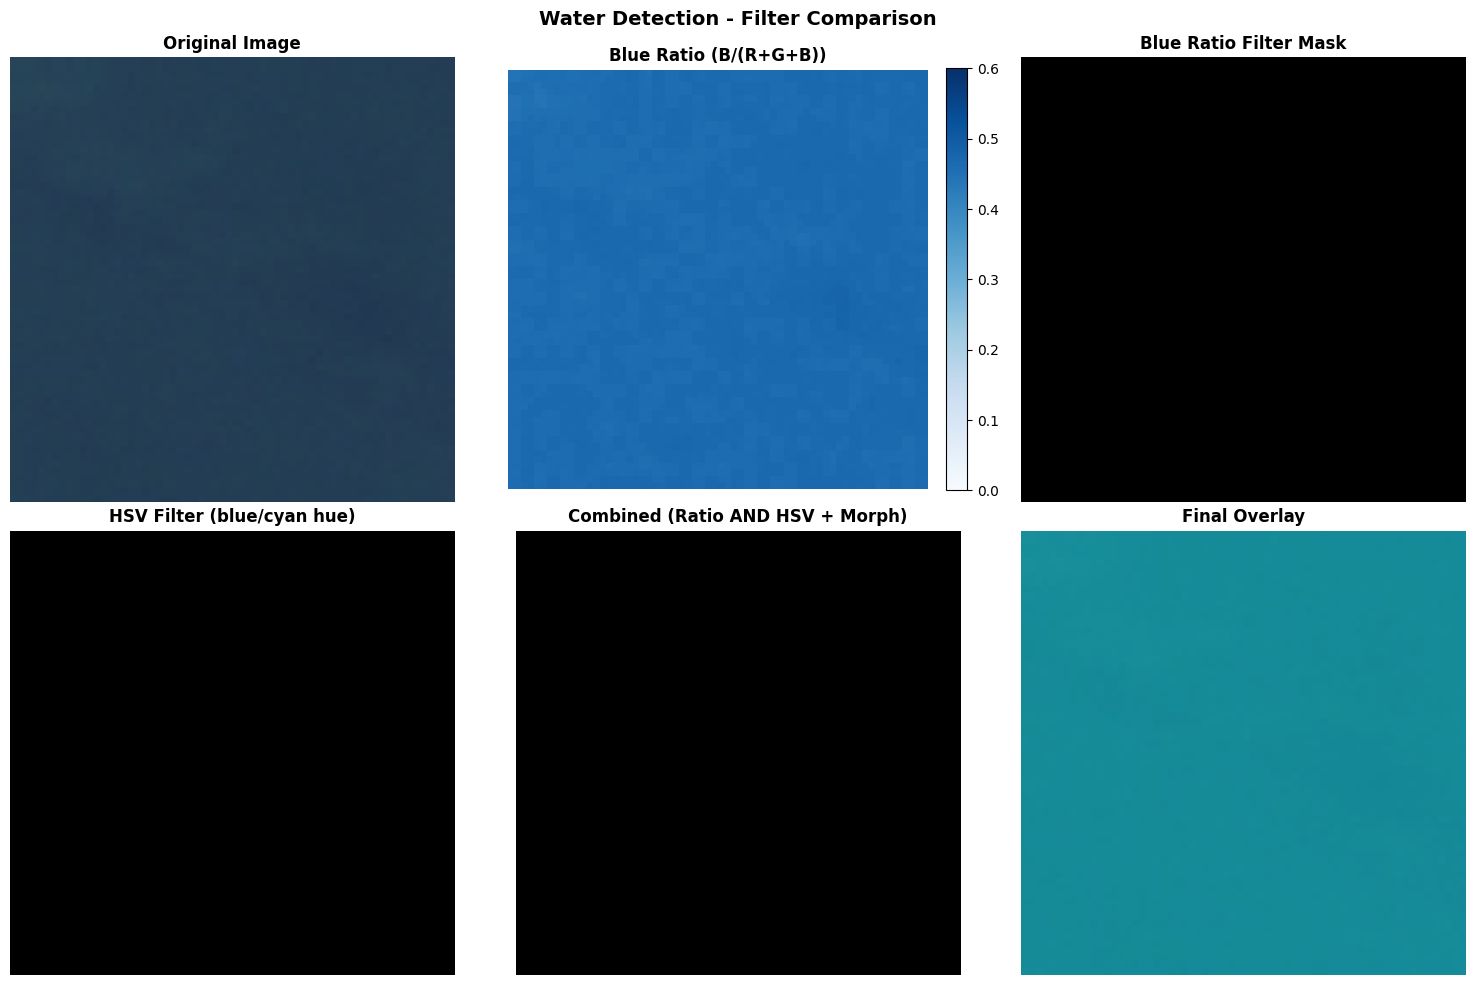

In [6]:
# Load water samples
water_samples = load_sample_images('water', n_samples=5)
print(f"Loaded {len(water_samples)} water images")

# Test filter on first water image
test_img = water_samples[0]
print(f"\nTesting on water image, shape: {test_img.shape}")

# Compare different filters
visualize_filter_comparison(test_img)

Testing water detection on multiple water images:


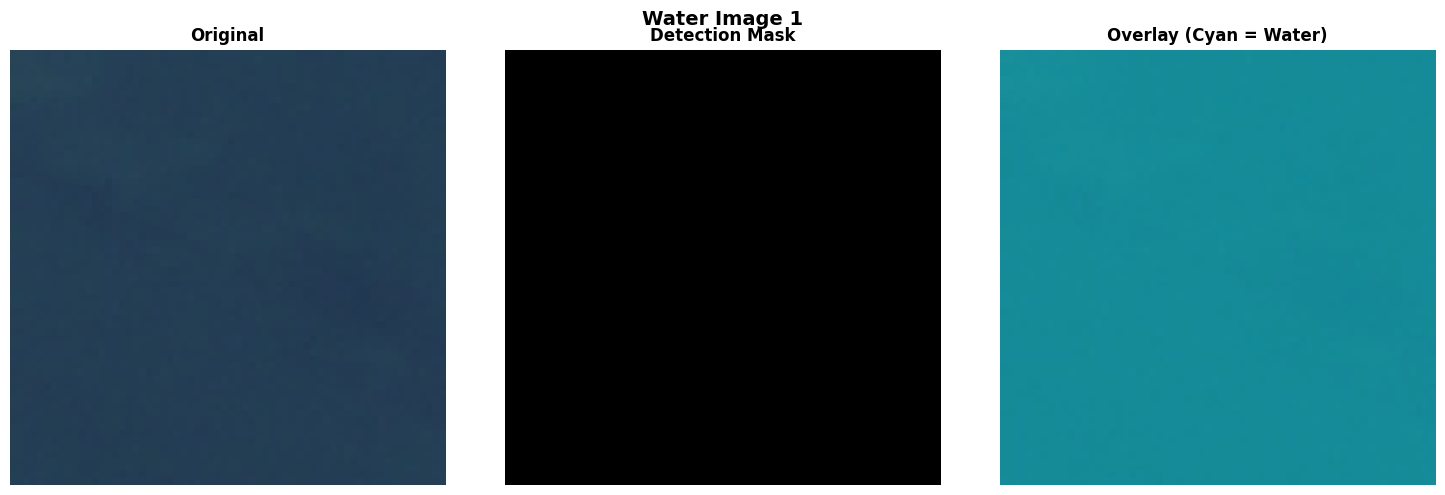

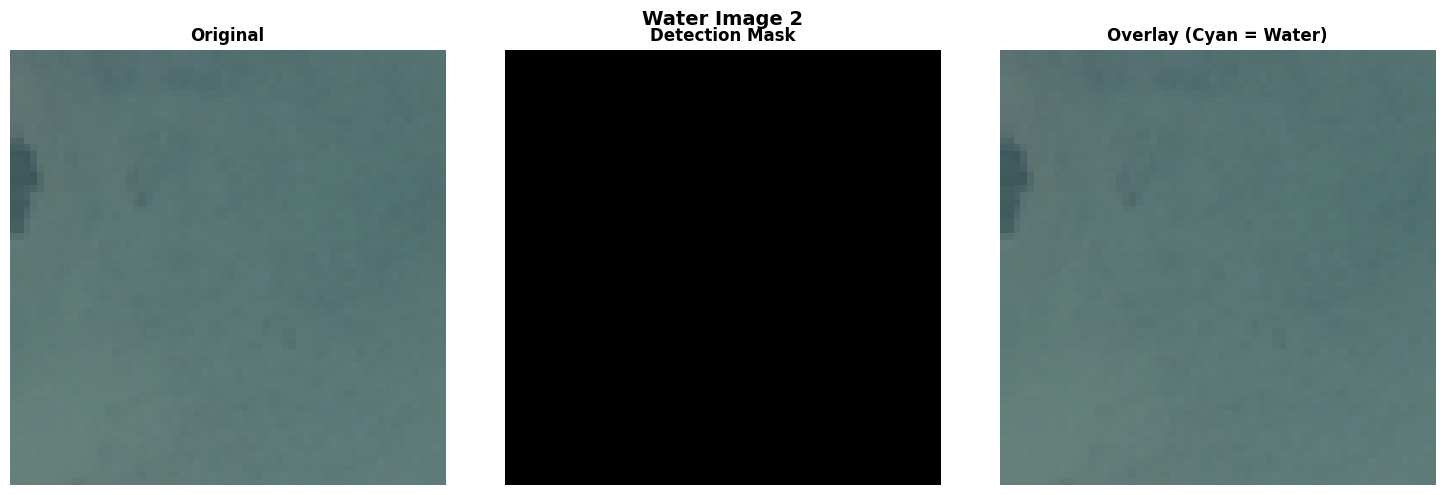

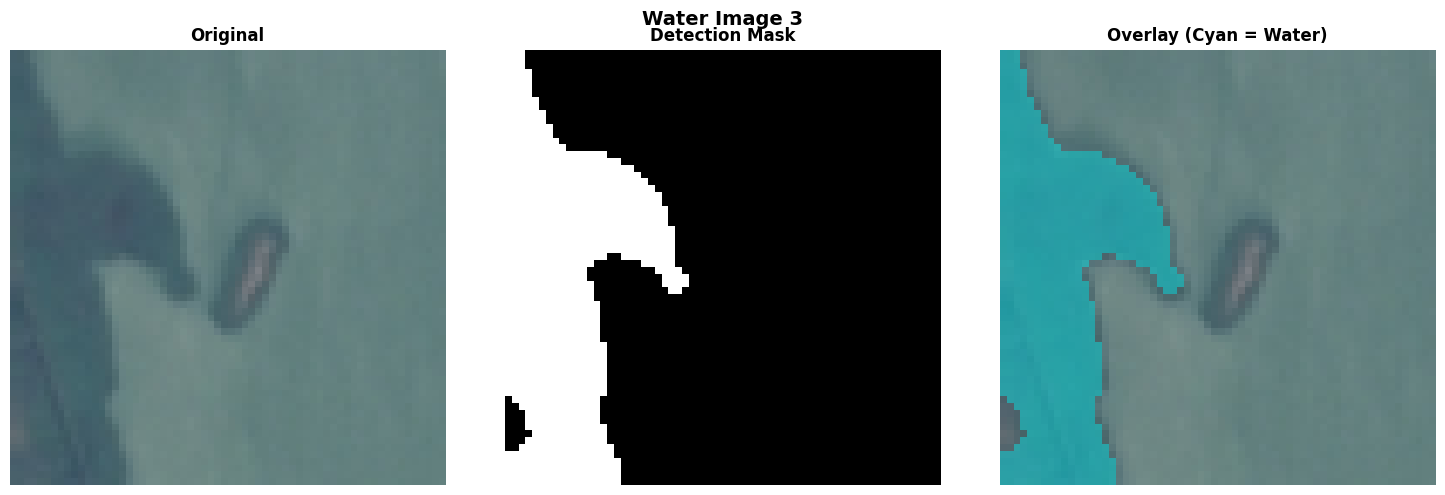

In [7]:
# Test on multiple water images
print("Testing water detection on multiple water images:")
for i, img in enumerate(water_samples[:3]):
    mask = detect_water_combined(img)
    visualize_detection(img, mask, title=f"Water Image {i+1}")

### 6.2 Test on Non-Water Images (Control)

Testing water detection on NON-water images:
(Should detect minimal or no water)

--- Cloudy ---


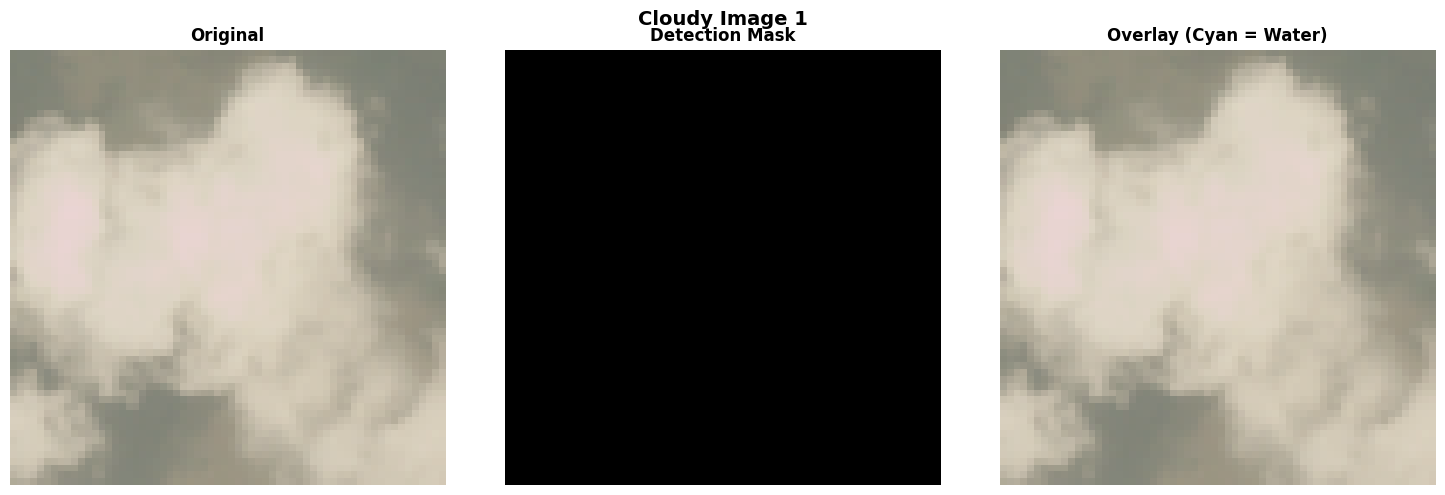

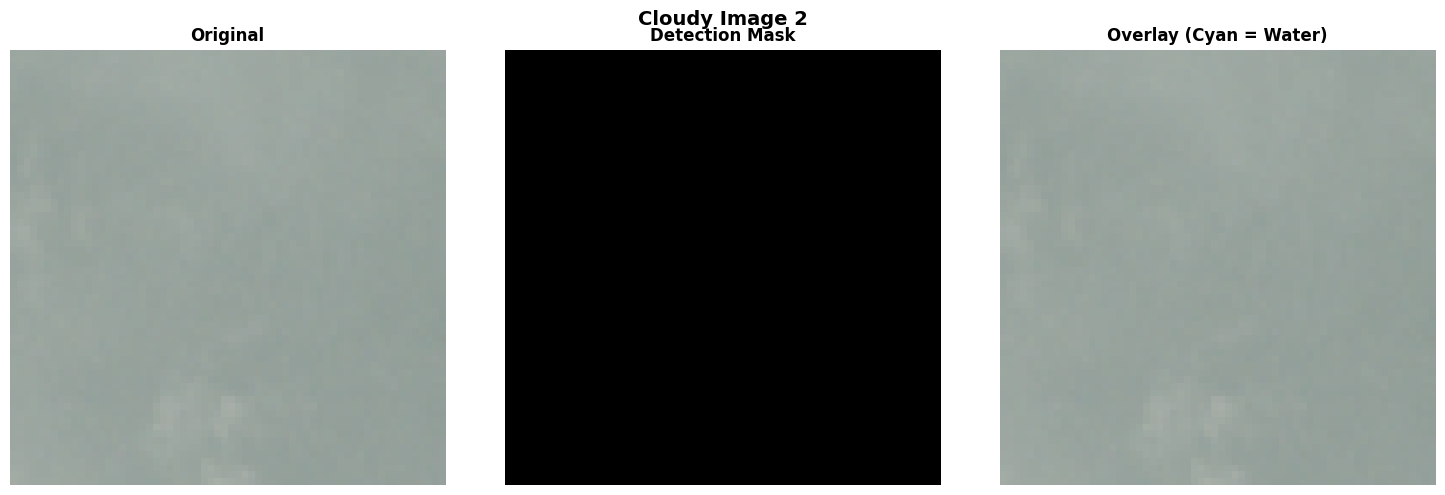

--- Desert ---


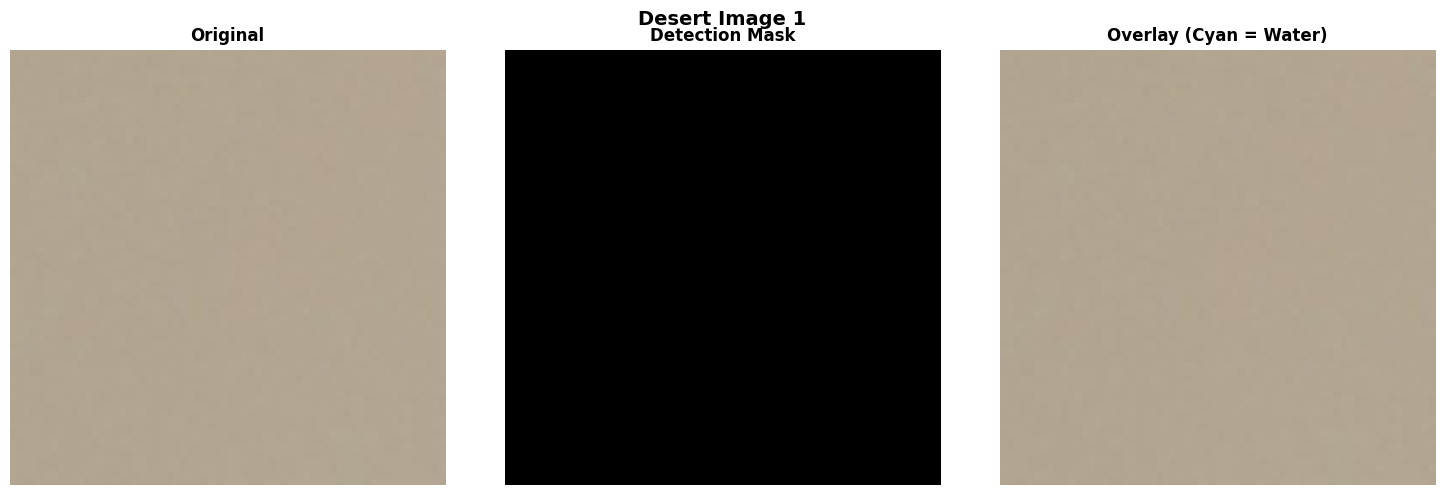

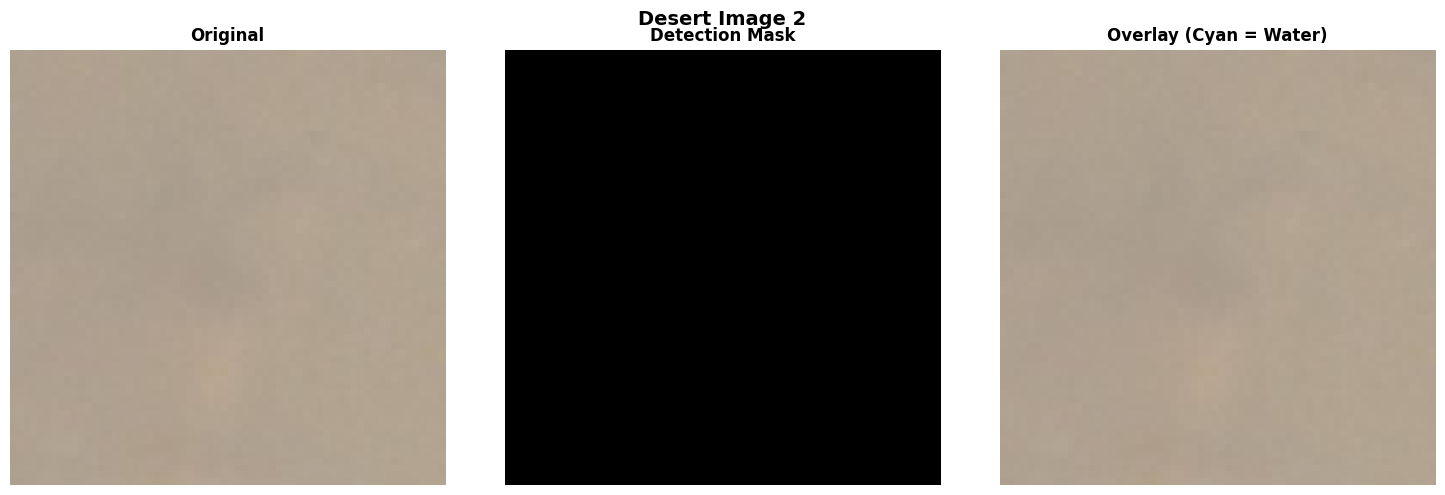

--- Vegetation ---


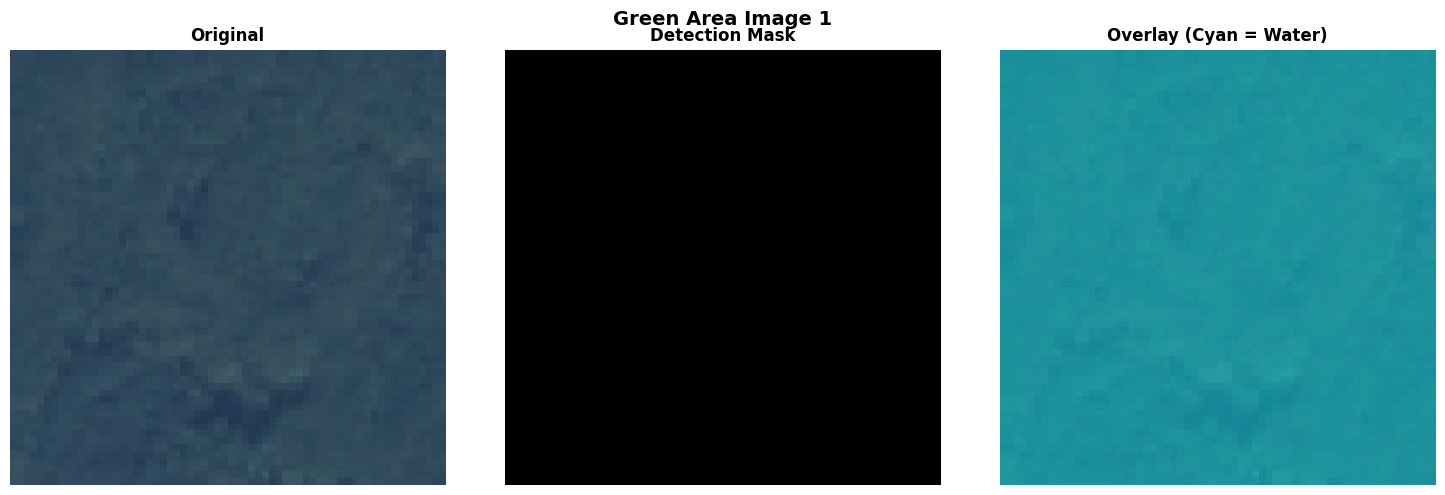

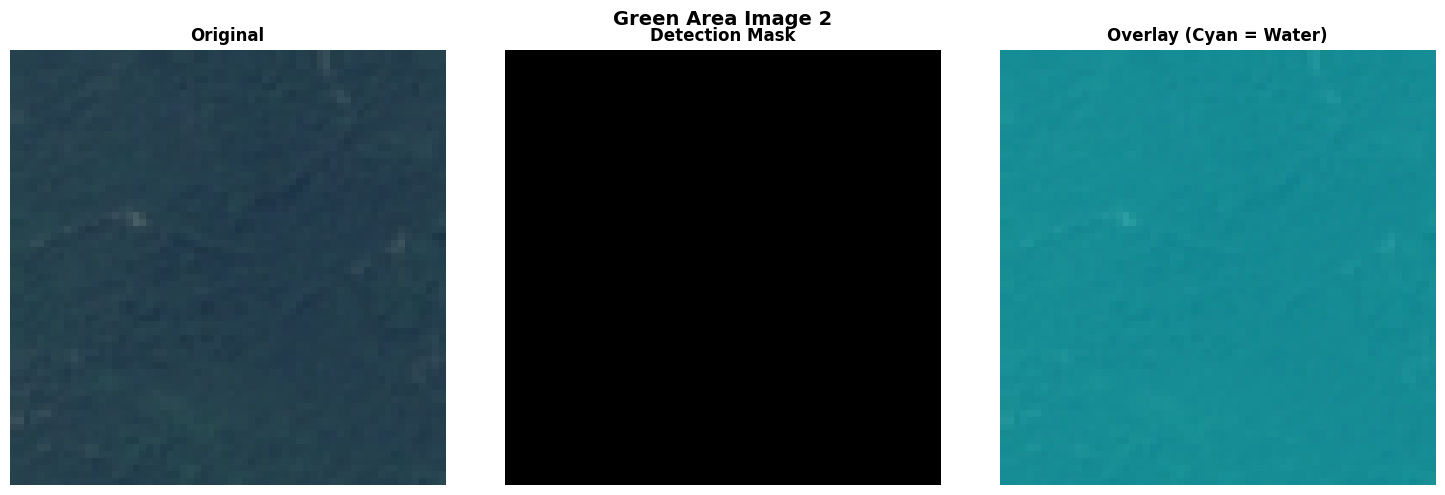

In [8]:
# Load samples from other categories
cloudy_samples = load_sample_images('cloudy', n_samples=2)
desert_samples = load_sample_images('desert', n_samples=2)
green_samples = load_sample_images('green_area', n_samples=2)

print("Testing water detection on NON-water images:")
print("(Should detect minimal or no water)\n")

# Test cloudy
print("--- Cloudy ---")
for i, img in enumerate(cloudy_samples):
    mask = detect_water_combined(img)
    visualize_detection(img, mask, title=f"Cloudy Image {i+1}")

# Test desert
print("--- Desert ---")
for i, img in enumerate(desert_samples):
    mask = detect_water_combined(img)
    visualize_detection(img, mask, title=f"Desert Image {i+1}")

# Test vegetation
print("--- Vegetation ---")
for i, img in enumerate(green_samples):
    mask = detect_water_combined(img)
    visualize_detection(img, mask, title=f"Green Area Image {i+1}")

## 7. Quantitative Evaluation

In [9]:
def calculate_water_coverage(mask: np.ndarray) -> float:
    """
    Calculate percentage of image covered by water.
    
    Args:
        mask: Binary mask (H, W)
    
    Returns:
        Percentage (0-100)
    """
    total_pixels = mask.size
    water_pixels = np.sum(mask > 0)
    return (water_pixels / total_pixels) * 100


def evaluate_filter_on_category(category: str, n_samples: int = 20) -> dict:
    """
    Evaluate water filter on a category and compute statistics.
    
    Returns:
        dict with mean, std, min, max water coverage percentage
    """
    images = load_sample_images(category, n_samples)
    coverages = []
    
    for img in images:
        mask = detect_water_combined(img)
        coverage = calculate_water_coverage(mask)
        coverages.append(coverage)
    
    return {
        'mean': np.mean(coverages),
        'std': np.std(coverages),
        'min': np.min(coverages),
        'max': np.max(coverages)
    }


print("Evaluating water detection across all categories...\n")

results = {}
for category in CATEGORIES:
    print(f"Processing {category}...")
    results[category] = evaluate_filter_on_category(category, n_samples=20)

print("\n" + "="*70)
print("WATER COVERAGE STATISTICS (%)")
print("="*70)
for category in CATEGORIES:
    stats = results[category]
    print(f"\n{category.replace('_', ' ').title()}:")
    print(f"  Mean:   {stats['mean']:.2f}%")
    print(f"  Std:    {stats['std']:.2f}%")
    print(f"  Range:  {stats['min']:.2f}% - {stats['max']:.2f}%")

print("\n" + "="*70)
print("Expected: Water images should have HIGH coverage (>50%)")
print("          Other categories should have LOW coverage (<20%)")
print("="*70)

Evaluating water detection across all categories...

Processing cloudy...
Processing desert...
Processing green_area...
Processing water...

WATER COVERAGE STATISTICS (%)

Cloudy:
  Mean:   0.00%
  Std:    0.00%
  Range:  0.00% - 0.00%

Desert:
  Mean:   0.00%
  Std:    0.00%
  Range:  0.00% - 0.00%

Green Area:
  Mean:   89.40%
  Std:    28.66%
  Range:  0.24% - 100.00%

Water:
  Mean:   86.00%
  Std:    31.40%
  Range:  0.00% - 100.00%

Expected: Water images should have HIGH coverage (>50%)
          Other categories should have LOW coverage (<20%)


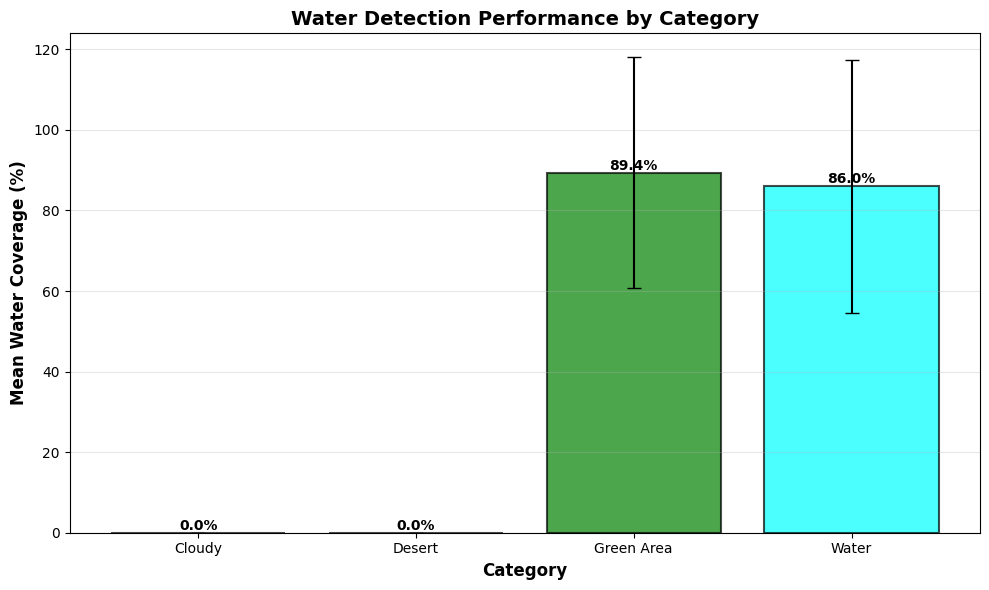

In [10]:
# Visualize results as bar chart
categories_labels = [cat.replace('_', ' ').title() for cat in CATEGORIES]
means = [results[cat]['mean'] for cat in CATEGORIES]
stds = [results[cat]['std'] for cat in CATEGORIES]

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(categories_labels))
bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, 
              color=['skyblue', 'orange', 'green', 'cyan'],
              edgecolor='black', linewidth=1.5)

ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Water Coverage (%)', fontsize=12, fontweight='bold')
ax.set_title('Water Detection Performance by Category', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories_labels)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Parameter Tuning (Optional)

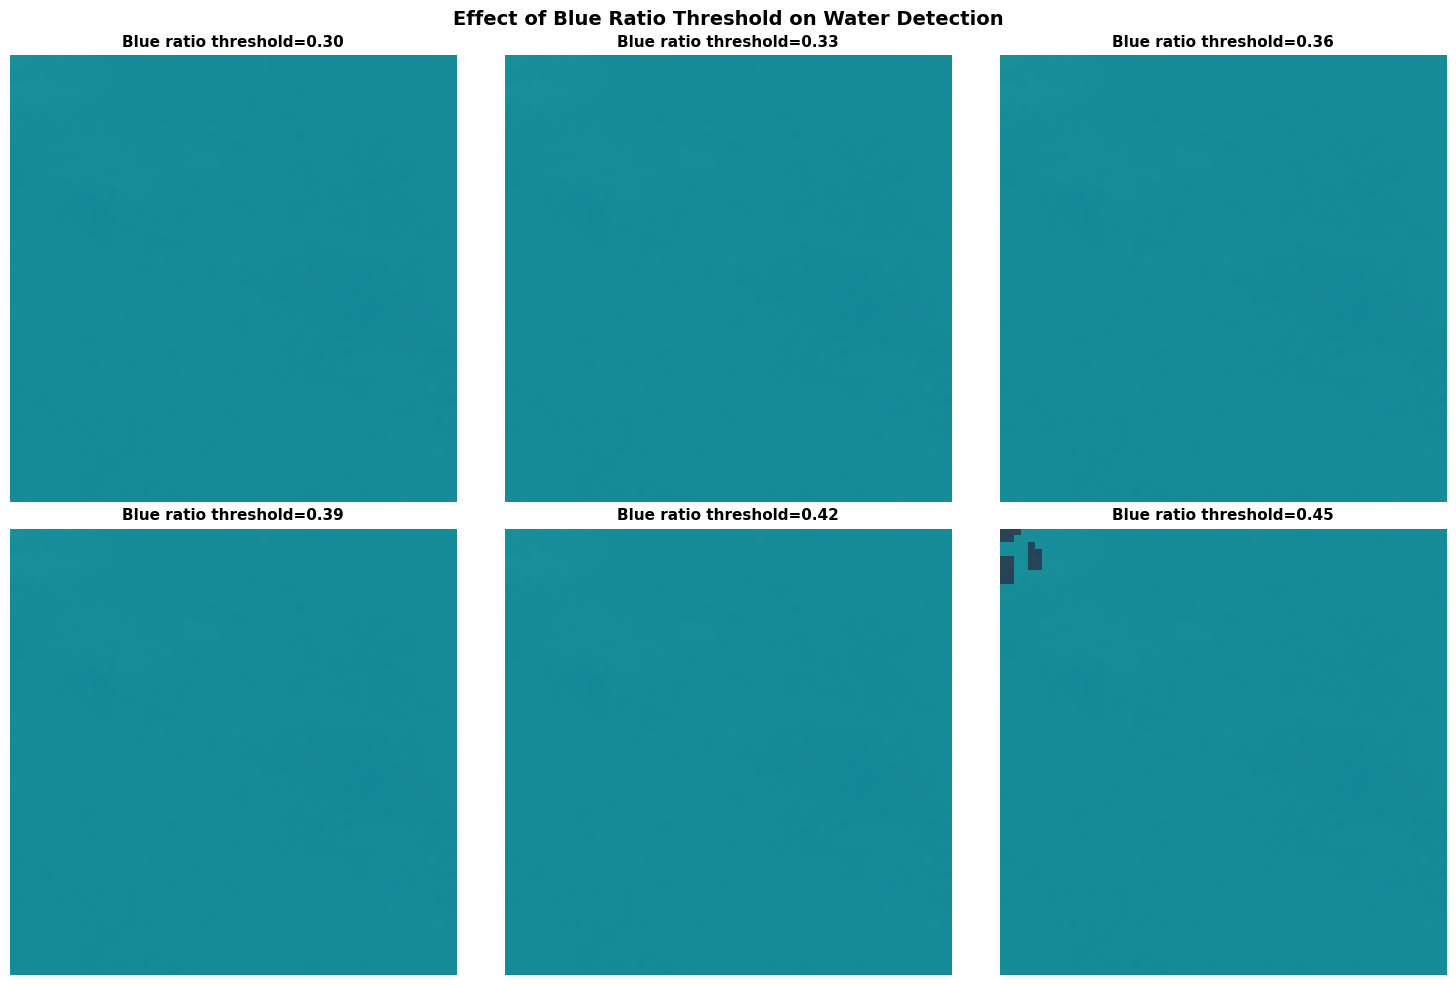

In [11]:
# Experiment with different blue ratio thresholds
test_img = water_samples[0]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

ratio_thresholds = [0.30, 0.33, 0.36, 0.39, 0.42, 0.45]

for idx, threshold in enumerate(ratio_thresholds):
    row = idx // 3
    col = idx % 3
    
    mask = detect_water_blue_ratio(test_img, threshold=threshold)
    overlay = apply_colored_overlay(test_img, mask)
    
    axes[row, col].imshow(overlay)
    axes[row, col].set_title(f'Blue ratio threshold={threshold:.2f}', fontsize=11, fontweight='bold')
    axes[row, col].axis('off')

plt.suptitle('Effect of Blue Ratio Threshold on Water Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

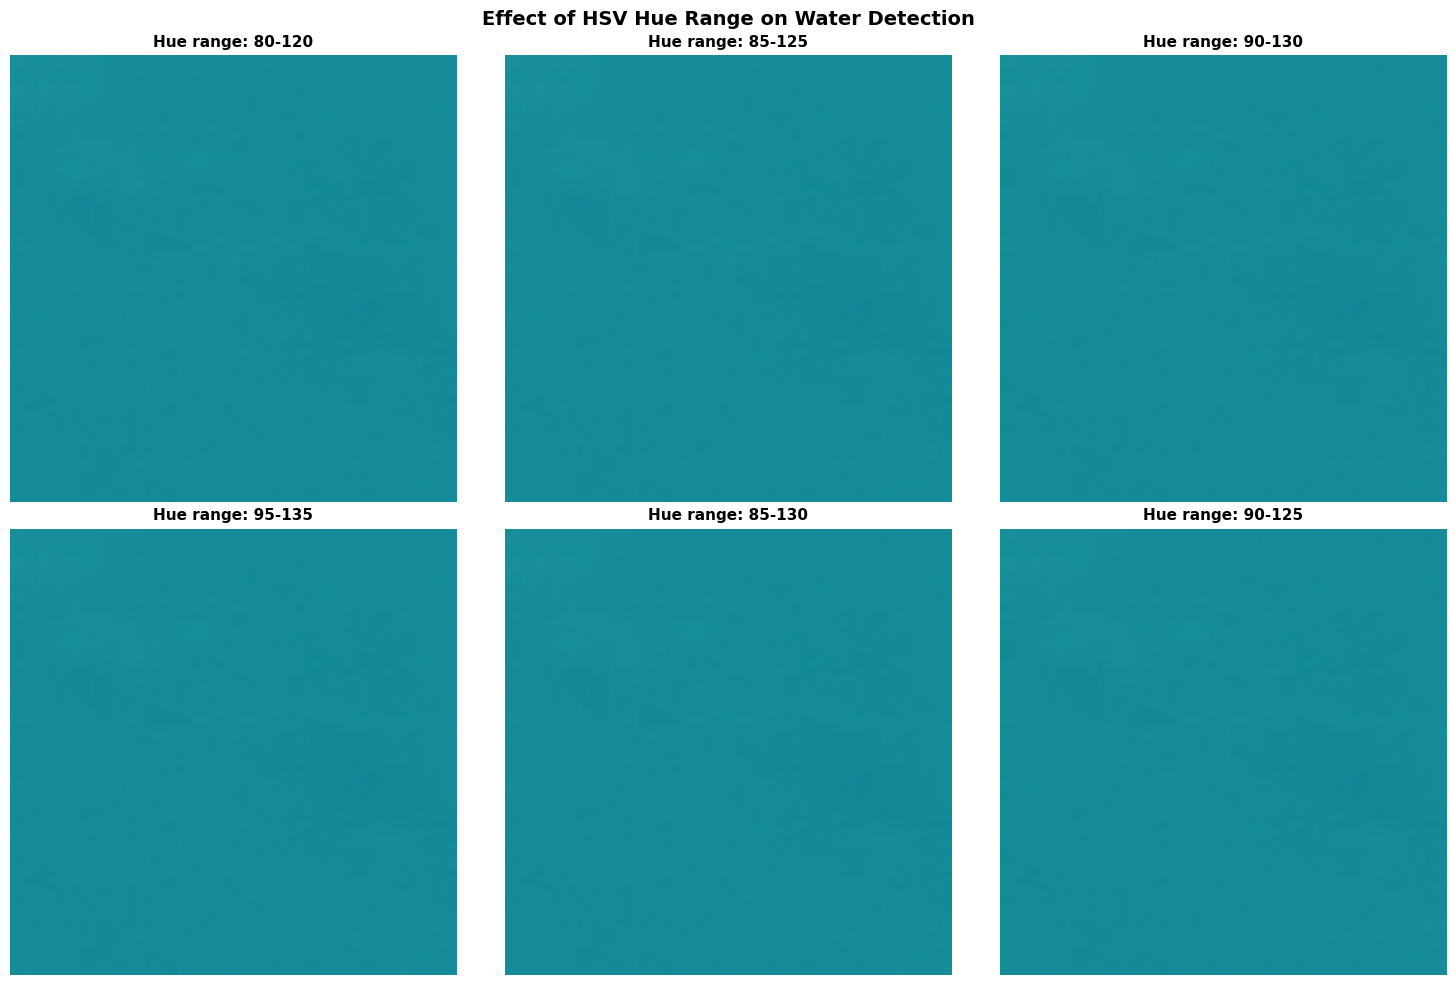

In [12]:
# Experiment with different HSV hue ranges
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Different blue/cyan hue ranges (min, max)
hue_ranges = [
    (80, 120),
    (85, 125),
    (90, 130),
    (95, 135),
    (85, 130),
    (90, 125)
]

for idx, (hue_min, hue_max) in enumerate(hue_ranges):
    row = idx // 3
    col = idx % 3
    
    mask = detect_water_hsv(test_img, hue_min=hue_min, hue_max=hue_max)
    overlay = apply_colored_overlay(test_img, mask)
    
    axes[row, col].imshow(overlay)
    axes[row, col].set_title(f'Hue range: {hue_min}-{hue_max}', fontsize=11, fontweight='bold')
    axes[row, col].axis('off')

plt.suptitle('Effect of HSV Hue Range on Water Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Comparison with Sky/Clouds

In [13]:
# Special test: check if filter can distinguish water from blue sky in cloudy images
print("Testing discrimination between water and blue sky:")
print("Water should have: blue hue + moderate-to-high blue ratio + NOT too bright\n")

# Test on a few cloudy images that might have blue sky
for i, img in enumerate(cloudy_samples):
    # Calculate metrics
    blue_ratio = calculate_blue_ratio(img)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    print(f"\nCloudy image {i+1}:")
    print(f"  Mean blue ratio: {np.mean(blue_ratio):.3f}")
    print(f"  Mean HSV Value (brightness): {np.mean(img_hsv[:,:,2]):.1f}")
    
    mask = detect_water_combined(img)
    coverage = calculate_water_coverage(mask)
    print(f"  Detected as water: {coverage:.2f}%")
    
    if coverage > 10:
        print("  ⚠ High false positive - might be confusing sky with water")
    else:
        print("  ✓ Good discrimination")

Testing discrimination between water and blue sky:
Water should have: blue hue + moderate-to-high blue ratio + NOT too bright


Cloudy image 1:
  Mean blue ratio: 0.309
  Mean HSV Value (brightness): 186.5
  Detected as water: 0.00%
  ✓ Good discrimination

Cloudy image 2:
  Mean blue ratio: 0.333
  Mean HSV Value (brightness): 163.2
  Detected as water: 0.00%
  ✓ Good discrimination


## 10. Summary

In [14]:
print("\n" + "="*70)
print("WATER DETECTION FILTER - SUMMARY")
print("="*70)

print("\nFilters Implemented:")
print("  1. Blue Ratio Filter: B/(R+G+B) >= threshold")
print("  2. HSV Filter: Blue/cyan hue (90-130°) + saturation & value constraints")
print("  3. Combined: Blue Ratio AND HSV (conservative) + morphological cleaning")

print("\nKey Discriminators from Sky/Clouds:")
print("  - Value (brightness) upper limit to exclude bright sky")
print("  - Saturation minimum to exclude desaturated clouds")
print("  - AND combination requires BOTH blue ratio AND hue match")

print("\nVisualization:")
print("  - Overlay color: Cyan (semi-transparent)")
print("  - Side-by-side: Original | Mask | Overlay")
print("  - Blue ratio heatmap (Blues colormap)")

print("\nPerformance on test samples:")
for category in CATEGORIES:
    stats = results[category]
    print(f"  - {category.replace('_', ' ').title()}: {stats['mean']:.1f}% ± {stats['std']:.1f}%")

print("\nKey Insights:")
if results['water']['mean'] > 50:
    print("  ✓ Successfully detects water in water images (>50% coverage)")
else:
    print("  ⚠ Low detection in water images - consider tuning thresholds")

non_water_avg = np.mean([results[cat]['mean'] for cat in ['cloudy', 'desert', 'green_area']])
if non_water_avg < 20:
    print("  ✓ Low false positives in non-water images (<20% average)")
else:
    print("  ⚠ High false positives - consider stricter thresholds")

# Check cloudy specifically (most likely to have blue sky confusion)
if results['cloudy']['mean'] < 15:
    print("  ✓ Good discrimination from sky/clouds (<15% false positives)")
else:
    print("  ⚠ May confuse blue sky with water - check Value threshold")

print("\n" + "="*70)
print("✓ Water detection filter completed")
print("  Next step: Desert detection (04_filter_desert.ipynb)")
print("="*70)


WATER DETECTION FILTER - SUMMARY

Filters Implemented:
  1. Blue Ratio Filter: B/(R+G+B) >= threshold
  2. HSV Filter: Blue/cyan hue (90-130°) + saturation & value constraints
  3. Combined: Blue Ratio AND HSV (conservative) + morphological cleaning

Key Discriminators from Sky/Clouds:
  - Value (brightness) upper limit to exclude bright sky
  - Saturation minimum to exclude desaturated clouds
  - AND combination requires BOTH blue ratio AND hue match

Visualization:
  - Overlay color: Cyan (semi-transparent)
  - Side-by-side: Original | Mask | Overlay
  - Blue ratio heatmap (Blues colormap)

Performance on test samples:
  - Cloudy: 0.0% ± 0.0%
  - Desert: 0.0% ± 0.0%
  - Green Area: 89.4% ± 28.7%
  - Water: 86.0% ± 31.4%

Key Insights:
  ✓ Successfully detects water in water images (>50% coverage)
  ⚠ High false positives - consider stricter thresholds
  ✓ Good discrimination from sky/clouds (<15% false positives)

✓ Water detection filter completed
  Next step: Desert detection (04_